In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.font_manager as fm
import matplotlib as mpl
import ast
import json
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

from collections import Counter
from kiwipiepy import Kiwi


In [2]:
def read_parquet_from_gcs(file_names, gcs_prefix, key_path):
    dfs = {}
    for name in file_names:
        path = f"{gcs_prefix}/{name}.parquet"
        dfs[name] = pd.read_parquet(path, storage_options={"token": key_path})
    return dfs


file_list = ["hackle_events"]  


gcs_prefix = "gs://sprintda05-yoochang-bucket/hackle"
key_path = "./config/hackle_yoochang.json"

# gcs_prefix = "gs://codeit-project/votes"
# key_path = "./config/key.json"


dfs = read_parquet_from_gcs(file_list, gcs_prefix, key_path)

# # device_properties
# device_properties = dfs["device_properties"]
# hackle_events
hackle_events = dfs["hackle_events"]
# # hackle_properties
# hackle_properties = dfs["hackle_properties"]
# # user_properties
# user_properties = dfs["user_properties"]    

In [3]:
hackle_events.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN


In [4]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


In [5]:
hackle_events.session_id.nunique()

253616

In [6]:
# 1부터 시작하는 정수 인코딩
hackle_events["session_id_encoded"] = (
    hackle_events["session_id"].astype("category").cat.codes + 1
)

In [7]:
hackle_events.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id,session_id_encoded
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN,31497
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN,58874
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN,45898
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN,155123
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN,154275


In [8]:
hackle_events.session_id_encoded.min(), hackle_events.session_id_encoded.max()

(np.int32(1), np.int32(253616))

In [9]:
session_counts = (
    hackle_events.groupby("session_id_encoded")
    .size()
    .reset_index(name="event_count")
)


In [10]:
session_counts.head()

,session_id_encoded,event_count
0,1,2
1,2,50
2,3,2
3,4,2
4,5,42


In [11]:
session_counts.describe()

,session_id_encoded,event_count
count,253616.000000,253616.000000
mean,126808.500000,45.112765
std,73212.777273,115.665378
min,1.000000,1.000000
25%,63404.750000,10.000000
50%,126808.500000,22.000000
75%,190212.250000,45.000000
max,253616.000000,8157.000000


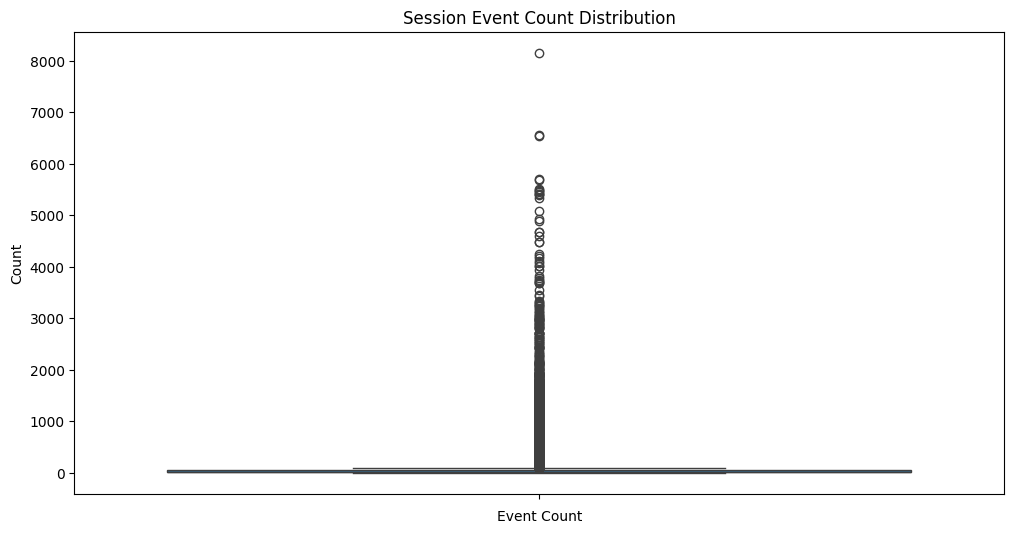

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(session_counts["event_count"])
plt.title("Session Event Count Distribution")
plt.xlabel("Event Count")
plt.ylabel("Count")
plt.show()

### 뭘 볼 수 있을까?

In [13]:
hackle_events.describe()

,event_datetime,friend_count,votes_count,heart_balance,question_id,session_id_encoded
count,11441319,1.068876e+07,1.068676e+07,1.071268e+07,449484.000000,1.144132e+07
mean,2023-07-29 01:58:17.236000,5.434357e+01,2.572742e+02,1.626929e+04,2766.385262,1.193410e+05
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000,1.000000e+00
25%,2023-07-22 21:31:17,3.200000e+01,9.700000e+01,4.340000e+02,1393.000000,5.319100e+04
50%,2023-07-28 17:08:58,4.900000e+01,2.100000e+02,1.249000e+03,2569.000000,1.155780e+05
75%,2023-08-04 17:59:10,7.100000e+01,3.620000e+02,3.188000e+03,4459.000000,1.826260e+05
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000,2.536160e+05
std,NaN,3.350798e+01,2.180682e+02,3.317340e+06,1599.967343,7.390297e+04


In [14]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   event_id            object        
 1   event_datetime      datetime64[ms]
 2   event_key           object        
 3   session_id          object        
 4   id                  object        
 5   item_name           object        
 6   page_name           object        
 7   friend_count        float64       
 8   votes_count         float64       
 9   heart_balance       float64       
 10  question_id         float64       
 11  session_id_encoded  int32         
dtypes: datetime64[ms](1), float64(4), int32(1), object(6)
memory usage: 1003.8+ MB


In [16]:
hackle_events['votes_count'].describe().round(2)

count    10686765.00
mean          257.27
std           218.07
min             0.00
25%            97.00
50%           210.00
75%           362.00
max          3017.00
Name: votes_count, dtype: float64

In [ ]:
hackle_events.event_key.value_counts()

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
click_question_ask                    136766
click_question_share                   69241


: 